--- 1. CEK NILAI NOL ATAU NEGATIF (YANG TIDAK WAJAR) ---
GDP aman (semua positif).
PERINGATAN: Ada 629 data BMI yang ekstrem (<10 atau >60).
Contoh:     Country    Year  BMI
25  Albania  2006.0  5.8
40  Algeria  2007.0  5.8

--- 2. CEK LOGIKA ANTAR KOLOM ---
Logika Kematian Bayi vs Balita aman.

--- 3. VISUALISASI OUTLIER (BOXPLOT) ---


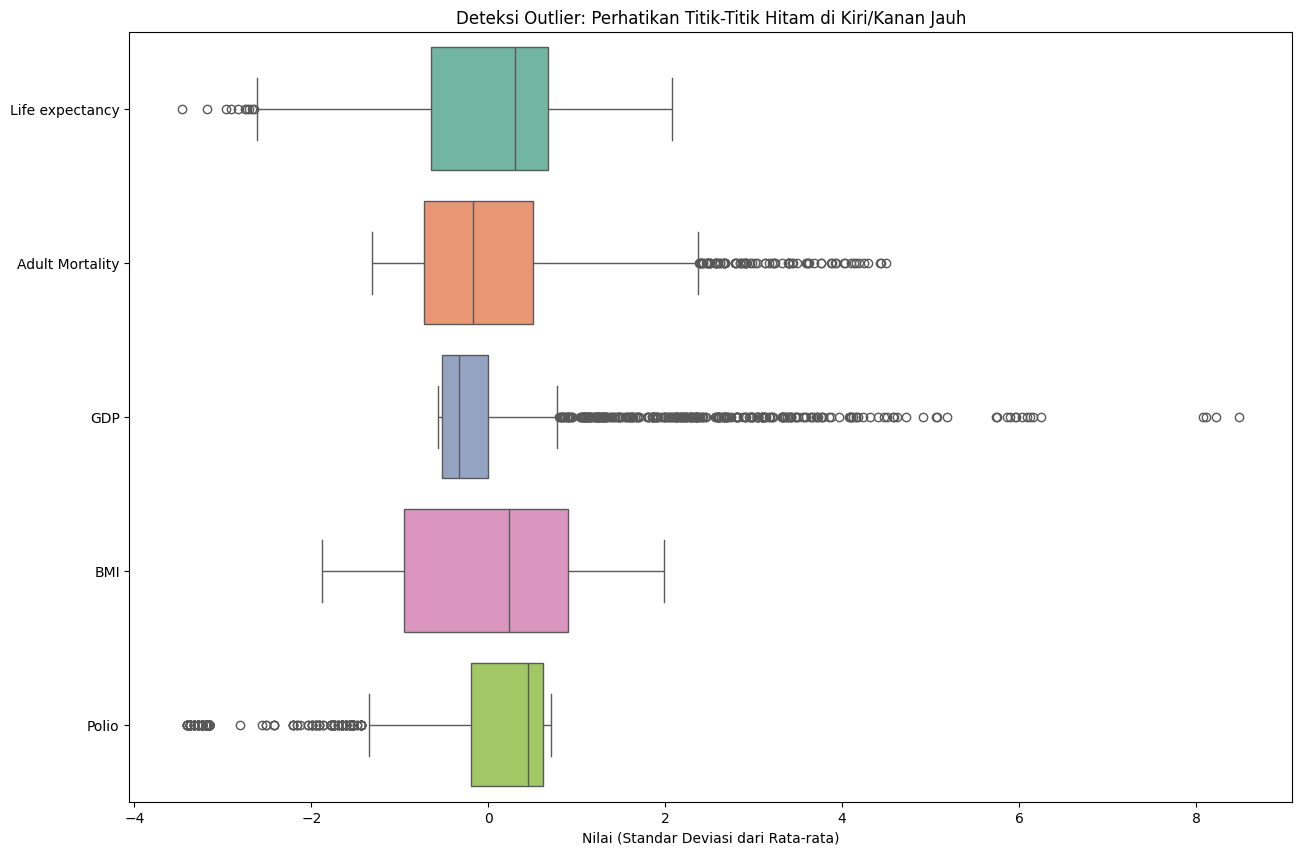

Perbaikan data
Menghapus 0 baris data kematian yang tidak logis.
   -> BMI: 347 data ekstrem (>60) diubah jadi NaN.
Pembersihan selesai. Siap masuk ke Interpolasi & Imputasi.

📊 HASIL EVALUASI MODEL:
--------------------------------------------------
Model: Linear Regression    | RMSE: 3.9396 | R2 Score: 0.8206
Model: Decision Tree        | RMSE: 2.5137 | R2 Score: 0.9269
Model: Random Forest        | RMSE: 1.7139 | R2 Score: 0.9660
Model: KNN                  | RMSE: 2.8855 | R2 Score: 0.9037
--------------------------------------------------
MODEL PALING AKURAT: Random Forest (Akurasi: 96.60%)

🔮 SIMULASI CUSTOM (Menggunakan Model Random Forest)
📍 Target Analisis : Japan (Tahun 2010)
--------------------------------------------------
🛠️ Skenario        : Menaikkan GDP sebesar 200%
📊 Nilai GDP Awal : 4457.68
📊 Nilai GDP Baru : 13373.03
--------------------------------------------------
🎯 Life Expectancy ASLI (Data) : 83.00 Tahun
🤖 Prediksi Model (Sebelum)    : 83.03 Tahun
🤖 Prediksi M

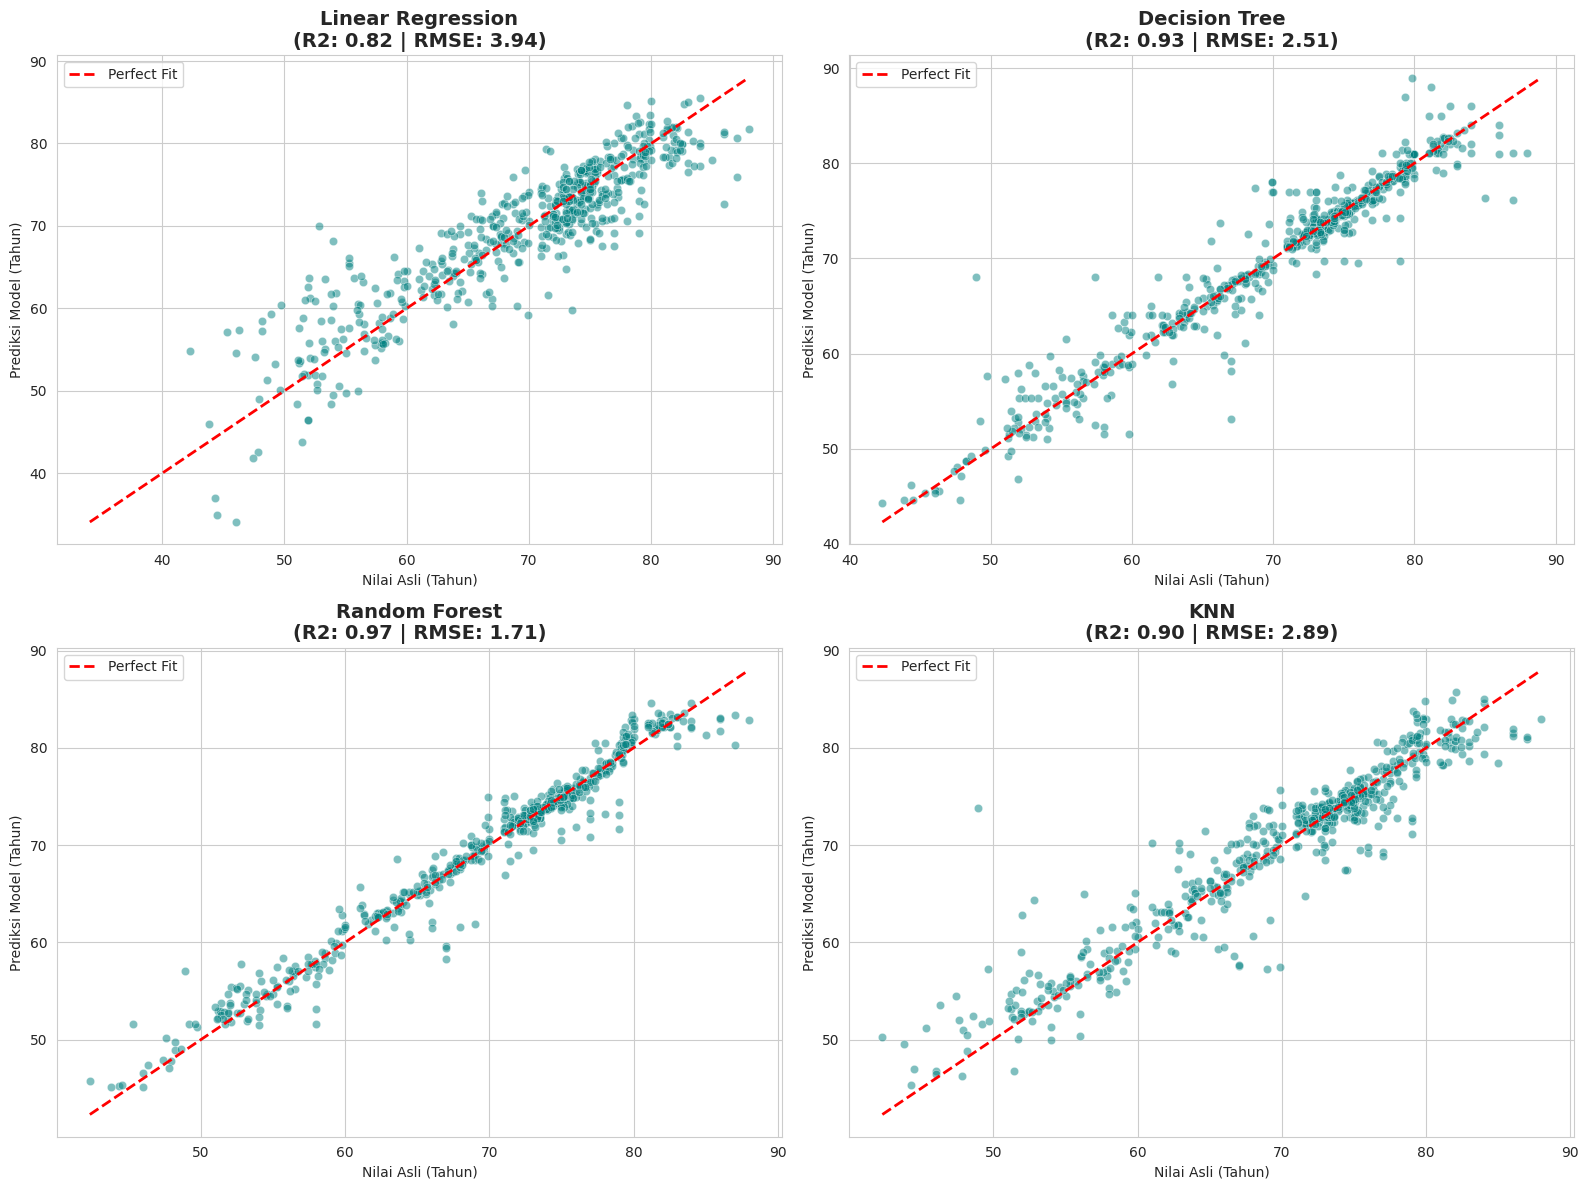

/tmp/ipykernel_1825/114517168.py:216: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices][:top_n], y=X_train.columns[indices][:top_n], palette='viridis')


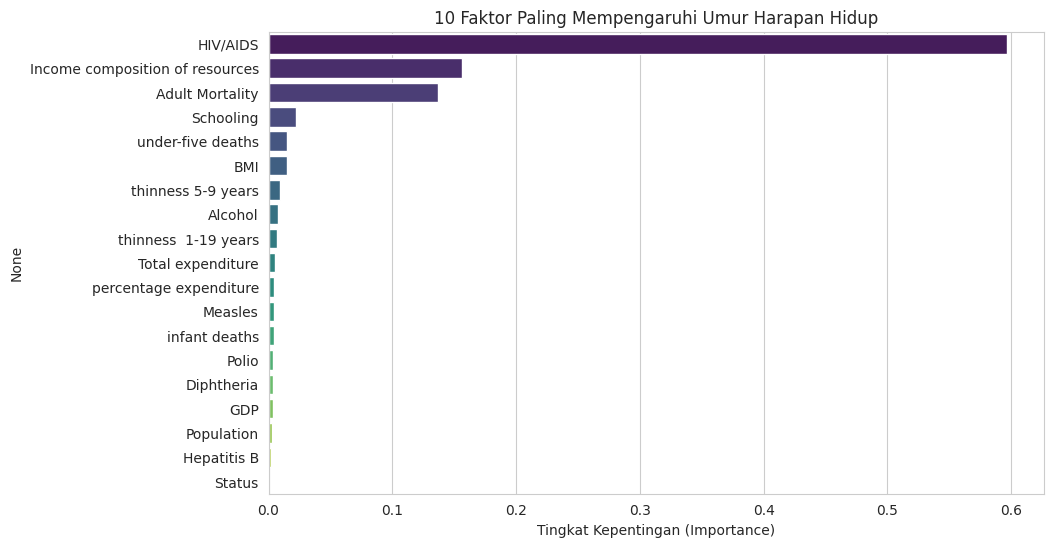

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load Data
df = pd.read_csv('Life Expectancy Data.csv')
df.columns = df.columns.str.strip() 
df = df.dropna(subset=['Life expectancy'])

# Mengisi data kosong dengan rata - rata
numeric_cols = df.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

# Encoding Status (Developing/Developed)
le = LabelEncoder()
df['Status'] = le.fit_transform(df['Status'])

df_train_full, df_test_full = train_test_split(df, test_size=0.2, random_state=42)

cols_to_drop = ['Life expectancy', 'Country', 'Year']

X_train = df_train_full.drop(cols_to_drop, axis=1)
y_train = df_train_full['Life expectancy']

X_test = df_test_full.drop(cols_to_drop, axis=1)
y_test = df_test_full['Life expectancy']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("--- 1. CEK NILAI NOL ATAU NEGATIF (YANG TIDAK WAJAR) ---")
cek_gdp = df[df['GDP'] <= 0]
if len(cek_gdp) > 0:
    print(f"PERINGATAN: Ada {len(cek_gdp)} data dengan GDP <= 0!")
else:
    print("GDP aman (semua positif).")

cek_bmi = df[(df['BMI'] > 60) | (df['BMI'] < 10)]
if len(cek_bmi) > 0:
    print(f"PERINGATAN: Ada {len(cek_bmi)} data BMI yang ekstrem (<10 atau >60).")
    print("Contoh:", cek_bmi[['Country', 'Year', 'BMI']].head(2))

print("\n--- 2. CEK LOGIKA ANTAR KOLOM ---")
cek_logika = df[df['infant deaths'] > df['under-five deaths']]

if len(cek_logika) > 0:
    print(f"🚨 BAHAYA: Ada {len(cek_logika)} baris data TIDAK LOGIS!")
    print("Bayi meninggal > Balita meninggal")
    print(cek_logika[['Country', 'Year', 'infant deaths', 'under-five deaths']].head())
else:
    print("Logika Kematian Bayi vs Balita aman.")

print("\n--- 3. VISUALISASI OUTLIER (BOXPLOT) ---")
plt.figure(figsize=(15, 10))

kolom_penting = ['Life expectancy', 'Adult Mortality', 'GDP', 'BMI', 'Polio']

df_norm = (df[kolom_penting] - df[kolom_penting].mean()) / df[kolom_penting].std()

sns.boxplot(data=df_norm, orient='h', palette='Set2')
plt.title('Deteksi Outlier: Perhatikan Titik-Titik Hitam di Kiri/Kanan Jauh')
plt.xlabel('Nilai (Standar Deviasi dari Rata-rata)')
plt.show()

print("Perbaikan data")

jumlah_awal = len(df)
df = df[df['infant deaths'] <= df['under-five deaths']]
print(f"Menghapus {jumlah_awal - len(df)} baris data kematian yang tidak logis.")

cols_positif = ['GDP', 'BMI', 'Polio', 'Diphtheria', 'Hepatitis B']

for col in cols_positif:
    count_err = len(df[df[col] <= 0])
    if count_err > 0:
        df.loc[df[col] <= 0, col] = np.nan
        print(f"   -> {col}: {count_err} data bernilai <=0 diubah jadi NaN.")

count_bmi = len(df[df['BMI'] > 60])
if count_bmi > 0:
    df.loc[df['BMI'] > 60, 'BMI'] = np.nan
    print(f"   -> BMI: {count_bmi} data ekstrem (>60) diubah jadi NaN.")


print("Pembersihan selesai. Siap masuk ke Interpolasi & Imputasi.")

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

print("\n📊 HASIL EVALUASI MODEL:")
print("-" * 50)

best_model = None
best_r2 = -1
best_name = ""

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"Model: {name:20} | RMSE: {rmse:.4f} | R2 Score: {r2:.4f}")
    
    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_name = name

print("-" * 50)
print(f"MODEL PALING AKURAT: {best_name} (Akurasi: {best_r2:.2%})")

print("\n" + "="*50)
print(f"🔮 SIMULASI CUSTOM (Menggunakan Model {best_name})")
print("="*50)

target_negara = "Japan"  
target_tahun  = 2010        
fitur_ubah    = "GDP"      
kenaikan_pct  = 200          


data_pilihan = df[(df['Country'] == target_negara) & (df['Year'] == target_tahun)]

if data_pilihan.empty:
    print(f"Data untuk {target_negara} tahun {target_tahun} tidak ditemukan di dataset.")
    print("Coba cek penulisan nama negara atau ganti tahunnya.")
else:
    cols_to_drop = ['Life expectancy', 'Country', 'Year']
    
    # Ambil fitur (X) dan target aslinya (y)
    X_sample = data_pilihan.drop(cols_to_drop, axis=1).copy()
    y_actual = data_pilihan['Life expectancy'].values[0]
    
    nilai_awal_fitur = X_sample[fitur_ubah].values[0]

    X_sample_scaled = scaler.transform(X_sample)
    pred_awal = best_model.predict(X_sample_scaled)[0]

    if fitur_ubah in ['Polio', 'Hepatitis B', 'Diphtheria']: 
        nilai_baru_fitur = min(nilai_awal_fitur * (1 + kenaikan_pct/100), 99.0)
    else:
        nilai_baru_fitur = nilai_awal_fitur * (1 + kenaikan_pct/100)
        
    X_sample[fitur_ubah] = nilai_baru_fitur
    
    X_sample_new_scaled = scaler.transform(X_sample)
    pred_baru = best_model.predict(X_sample_new_scaled)[0]

    print(f"📍 Target Analisis : {target_negara} (Tahun {target_tahun})")
    print(f"--------------------------------------------------")
    print(f"🛠️ Skenario        : Menaikkan {fitur_ubah} sebesar {kenaikan_pct}%")
    print(f"📊 Nilai {fitur_ubah} Awal : {nilai_awal_fitur:.2f}")
    print(f"📊 Nilai {fitur_ubah} Baru : {nilai_baru_fitur:.2f}")
    print(f"--------------------------------------------------")
    print(f"🎯 Life Expectancy ASLI (Data) : {y_actual:.2f} Tahun")
    print(f"🤖 Prediksi Model (Sebelum)    : {pred_awal:.2f} Tahun")
    print(f"🤖 Prediksi Model (Sesudah)    : {pred_baru:.2f} Tahun")
    
    selisih = pred_baru - pred_awal
    tanda = "+" if selisih > 0 else ""
    print(f"✨ DAMPAK KEBIJAKAN            : {tanda}{selisih:.4f} Tahun")


sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten() 

print("\nSedang membuat grafik perbandingan...")


for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    sns.scatterplot(x=y_test, y=y_pred, ax=axes[i], alpha=0.5, color='teal')
    
    
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
    
    axes[i].set_title(f"{name}\n(R2: {r2:.2f} | RMSE: {rmse:.2f})", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("Nilai Asli (Tahun)")
    axes[i].set_ylabel("Prediksi Model (Tahun)")
    axes[i].legend()

plt.tight_layout()
plt.show()

if best_name == "Random Forest":
    plt.figure(figsize=(10, 6))
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    top_n = 20
    sns.barplot(x=importances[indices][:top_n], y=X_train.columns[indices][:top_n], palette='viridis')
    plt.title('10 Faktor Paling Mempengaruhi Umur Harapan Hidup')
    plt.xlabel('Tingkat Kepentingan (Importance)')
    plt.show()